# Importando dataset

In [1]:
#Importar dataset como DataFrame
import pandas as pd

jogos = pd.read_csv('./dataset/datasetLudopedia.csv')

In [2]:
jogos = jogos[['Descrição', 'Temas']]

# Tratando os dados da coluna Temas

In [3]:
#Transformando a coluna Temas de str para array
from ast import literal_eval

tema_list = []
for tema in jogos.Temas:
    tema_list.append(literal_eval(tema))

jogos.Temas = tema_list

In [4]:
#Identificar jogos sem Temas cadastrados e excluindo-os
sem_tema = jogos[jogos['Temas'].str.len() == 0]
jogos = jogos.drop(sem_tema.index).reset_index(drop = True)

In [5]:
#Identificando quantidade de ocorrencias de cada tema e criando lista de temas únicos
from collections import Counter 
from itertools import chain

freq_temas = pd.DataFrame(pd.Series(Counter(chain(*jogos.Temas))))
temas = freq_temas.index

In [6]:
#Função para criar uma coluna para cada tema e varrer todas as linhas atribuindo 0 ou 1 caso tema presente no jogo
def adiciona_coluna(temas, dataframe, nome_coluna):
    for tema in temas:
        coluna = list()
        for linha in dataframe[nome_coluna]:
            if tema in linha:
                coluna.append(1)
            else:
                coluna.append(0)
        dataframe[tema] = coluna    

In [7]:
#Chama a função e cria as colunas identificando a presença do tema de forma binária 
adiciona_coluna(temas, jogos, 'Temas')

In [9]:
#Criar uma única coluna que representa os temas de um jogo de forma compatível com os algoritmos de classificação
#usa a função zip() juntando todos os elementos de uma lista num único elemento
todos_temas = []
for tema in temas:
    todos_temas.append(jogos[tema])

jogos['Todos Temas'] = list(zip(*todos_temas))

# Tratando os dados e aplicando PLN na coluna Descrição

In [12]:
#identificando e excluindo jogos sem Descrição
sem_descricao = jogos[jogos['Descrição'].isna()]
jogos = jogos.drop(sem_descricao.index).reset_index(drop = True)

In [13]:
#Criando função para visualização de Nuvem de Palavras para ajudar na análise dos dados
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plotar_nuvem(dataframe, nome_coluna):
    #junta todas as frases numa unica variavel
    todas_palavras = ''.join([texto for texto in dataframe[nome_coluna]])
    #gerar nuvem de palavras
    nuvem_palavras = WordCloud(width = 800, height = 500,
                              max_font_size=110,
                              background_color='white',
                              collocations= False).generate(todas_palavras)
    #plotar a nuvem de palavras com MatplotLib
    plt.figure(figsize=(14,9))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis(False)
    plt.show()


In [14]:
#Criando função para desenhar gráfico de Pareto com frequência das palavras
import nltk
import seaborn as sns
from nltk import tokenize

token_espaco = tokenize.WhitespaceTokenizer()#separa por espaço

def pareto(dataframe, nome_coluna, quantidade):
    todas_palavras = ''.join([texto for texto in dataframe[nome_coluna]])
    token_frase = token_espaco.tokenize(todas_palavras) 
    frequencia = nltk.FreqDist(token_frase)
    df_frequencia = pd.DataFrame({'Palavra' : list(frequencia.keys()), 'Frequencia' : frequencia.values()})
    df_frequencia = df_frequencia.nlargest(columns = "Frequencia", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x = 'Palavra', y = 'Frequencia', color = 'gray')
    ax.set(ylabel = 'Contagem')
    plt.show()

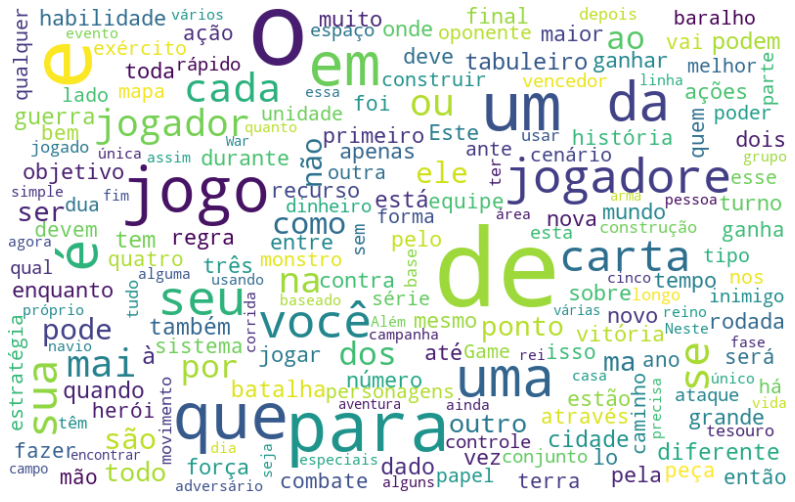

In [15]:
#Visualizando nuvem de palavras das Descricoes dos jogos sem tratamento
plotar_nuvem(jogos, 'Descrição')

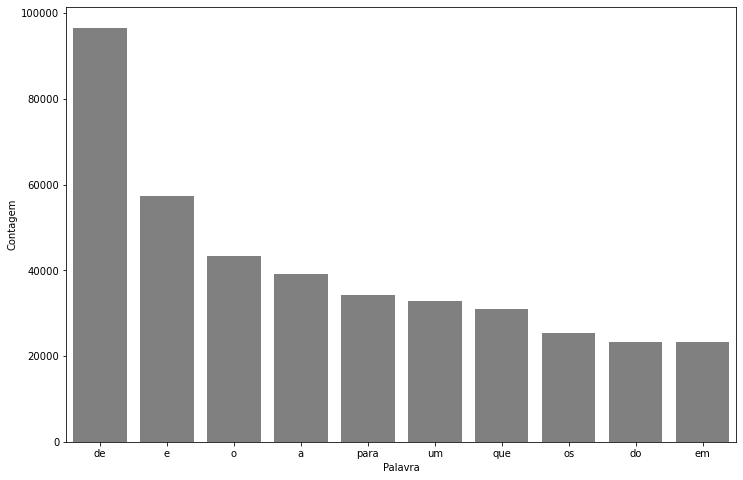

In [16]:
#Visualizar gráfico de Pareto com 10 palavras mais frequentes da coluna Descricao sem tratamento
pareto(jogos, 'Descrição', 10)

In [19]:
#Funcao para Realizar todo o tratamento PLN de uma vez só
import nltk
from nltk import tokenize
from string import punctuation
from unidecode import unidecode

token_pontuacao = tokenize.WordPunctTokenizer() #cria tokenizador
stemmer = nltk.RSLPStemmer()
stopwords = nltk.corpus.stopwords.words('portuguese') #importa lista de stopwords
pontuacao = list() #cria lista de pontuacao e adiciona a lista de stopwords

for ponto in punctuation:
    pontuacao.append(ponto)
    
stopwords = pontuacao + stopwords
stopwords = [unidecode(texto) for texto in stopwords] #retira os acentos das stopwords

def trata_texto(dataframe, nome_coluna):
    frase_processada = list()
    for descricao in dataframe[nome_coluna]:
        nova_frase = list()
        descricao = descricao.lower() #lower() passa para minusculo
        palavras_texto = token_pontuacao.tokenize(unidecode(descricao)) #unidecode() retira acentos
        for palavra in palavras_texto:
            if palavra not in stopwords: #filtra palavras presente na lista de stopwords sem acento e minusculas
                nova_frase.append(stemmer.stem(palavra)) #stemmer reduz o radical da palavras
        frase_processada.append(' '.join(nova_frase))

    dataframe[nome_coluna+'_tratada'] = frase_processada
    return dataframe[nome_coluna+'_tratada']

In [21]:
#chama funcao realizando o PLN
trata_texto(jogos, 'Descrição')

0        gloomhaven jog combat tatic inspir eur mund pe...
1        terr mys habit 14 pov difer set pais cad grup ...
2        ano 2400 human comec terraform planet mart cor...
3        projet gai nov jog linh terr mys terr mys orig...
4        jog econom estrateg sequenc obr prim martin wa...
                               ...                        
13535    "! mia !" signif min !" pont princip jog resol...
13536    prim volum seri ludopres sobr guerr civil espa...
13537    pens tac tuesday prest jog pilh com sabor amig...
13538    pasaran guerr civil espanhol jog auton usa sis...
13539    lowcy zwierzat jog mov pec cac desert hexagon ...
Name: Descrição_tratada, Length: 13540, dtype: object

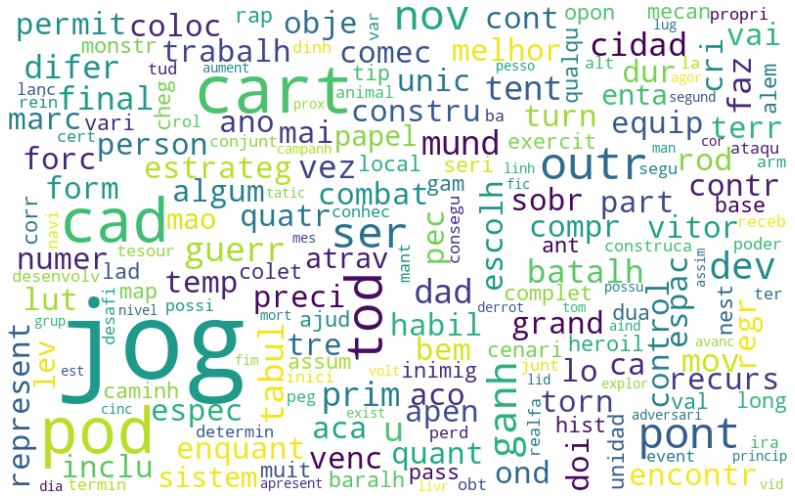

In [22]:
#Visualiza nuvem de palavras com a colunda Descricao_tratada
plotar_nuvem(jogos, 'Descrição_tratada')

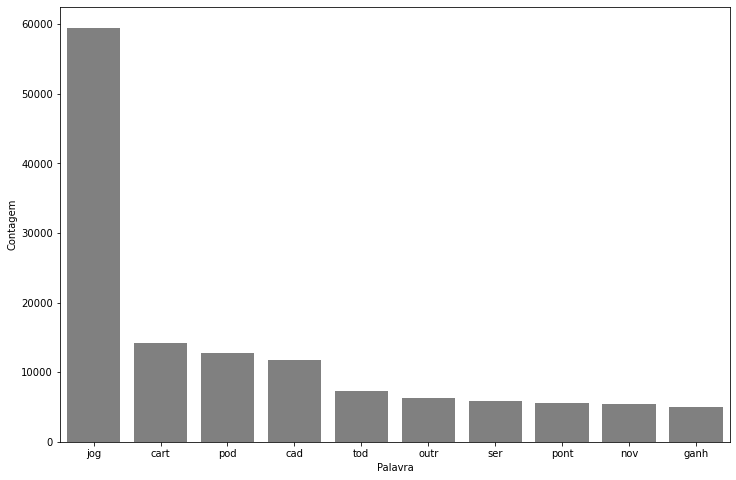

In [23]:
#Visualiza grafico pareto com a colunda Descricao_tratada
pareto(jogos, 'Descrição_tratada', 10)

# Separação de dados de treino e teste, e ajustes para rodas os modelos

In [32]:
#funcao para chamar os modelos com diferentes parametros
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.adapt import MLkNN
from sklearn.metrics import hamming_loss

regressao_logistica = LogisticRegression()  #declara o estimador

#Instanciacao dos modelos de machine learning
onevsrest = OneVsRestClassifier(regressao_logistica) 
chain = ClassifierChain(regressao_logistica)
mlknn = MLkNN()

def classificar(descricao, feat, df, classificador):
    

    tfidf = TfidfVectorizer(max_df = df, max_features= feat)
    
    descricao_treino, descricao_test, temas_treino, temas_teste = train_test_split(
        jogos[descricao],   #argumento
        jogos['Todos Temas'],  #argumento
        test_size = 0.2,          #define porcentagem da amostra para teste
        random_state = 111         #define paramentro de ramdomizacao para possivel replicacao
    )

    tfidf.fit(jogos[descricao].values.astype('U'))
    descricao_treino_tfidf = tfidf.transform(descricao_treino.values.astype('U'))
    descricao_test_tfidf = tfidf.transform(descricao_test.values.astype('U'))  

    temas_treino_array = np.asarray(list(temas_treino))
    temas_teste_array = np.asarray(list(temas_teste))
    
    #inicia o treino do modelo com fit() passando o dados de treino
    classificador.fit(descricao_treino_tfidf, temas_treino_array)
    
    #capturar o resultado do modelo treinado atraves da funcao score()
    acuracia = classificador.score(descricao_test_tfidf, temas_teste_array)
    
    #Classifica os dados de teste com o modelo treinado através da funcao predict() e calcula o HL com o resultado
    previsao = classificador.predict(descricao_test_tfidf)
    hl = hamming_loss(temas_teste_array, previsao)
        
    print(classificador)
    print('Acurácia {0: .4f}%'.format(acuracia*100))
    print("Hamming Loss {0: .4f}".format(hl))


In [33]:
classificar("Descrição", 5000, 0.5, onevsrest)

OneVsRestClassifier(estimator=LogisticRegression())
Acurácia  18.5746%
Hamming Loss  0.0377


In [34]:
classificar("Descrição_tratada", 5000, 0.5, onevsrest)

OneVsRestClassifier(estimator=LogisticRegression())
Acurácia  20.6425%
Hamming Loss  0.0364


In [35]:
classificar("Descrição",5000, 0.5, chain)

ClassifierChain(classifier=LogisticRegression(), require_dense=[True, True])
Acurácia  20.1994%
Hamming Loss  0.0372


In [36]:
classificar("Descrição_tratada",5000, 0.5, chain)

ClassifierChain(classifier=LogisticRegression(), require_dense=[True, True])
Acurácia  22.2674%
Hamming Loss  0.0360


In [37]:
classificar("Descrição",5000, 0.5, mlknn)

C:\Users\glaub\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


MLkNN()
Acurácia  25.1108%
Hamming Loss  0.0379


In [38]:
classificar("Descrição_tratada",5000, 0.5, mlknn)

MLkNN()
Acurácia  26.1448%
Hamming Loss  0.0365
